In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.stattools import acf, pacf

 

csv_file = 'CRAC3_residual.csv'

 
#ACF and PACF plots:
print 'reading from '+csv_file
rcParams['figure.figsize'] = 15, 6
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d %H:%M:%S')
# dateparse('2018-05-16 14:41:00')
data = pd.read_csv(csv_file, parse_dates=[0], index_col=0,date_parser=dateparse)
data.index = pd.DatetimeIndex(data.index.values,
                               freq=data.index.inferred_freq)
#print data.index
#print data.head()
#print data.dtypes
ts = data['Consumed_active_energy_kW']
#print ts

font = {'family' : 'arial',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)



#Plot rolling statistics:
ts_log = np.log(ts)
#eliminate stationary
#difference
ts_log_diff = ts_log - ts_log.shift()
#plt.plot(ts_log_diff,color='green',ls='-',label='log_shift_diff')
ts_log_diff.dropna(inplace=True)

lag_acf = acf(ts_log_diff, nlags=100)
lag_pacf = pacf(ts_log_diff, nlags=100, method='ols')
#Plot ACF: 
plt.subplot(121) 
plt.grid("on")
plt.xlabel("Lag")
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.xlabel("Lag")
plt.grid("on")
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()
plt.savefig( 'PAF.png')




reading from CRAC3_residual.csv


ARIMA parameter p,d,q (10,1,10)
train_size 48887 test_size 24080



/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


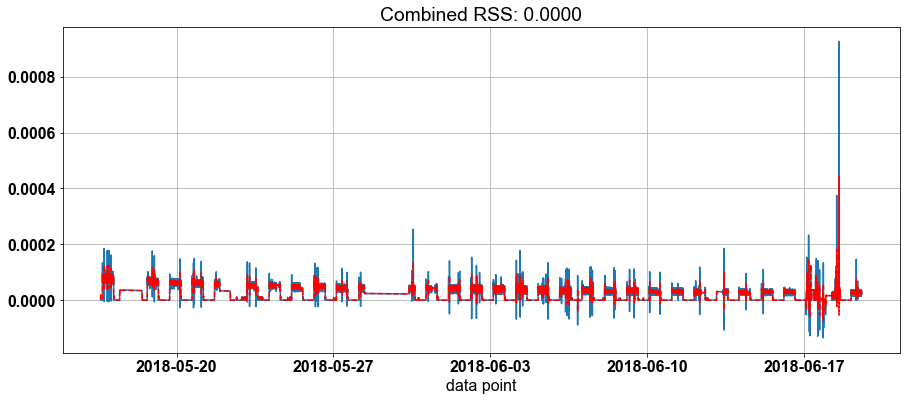

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose
res_file = open( 'acf-score.txt','a')
#decompfreq = 60 

#decomposition = seasonal_decompose(ts_log, freq=decompfreq )
#trend = decomposition.trend
#seasonal = decomposition.seasonal
#residual = decomposition.resid

d = 1
p = 10
q = 10

res_file.write('%d,%d,%d,'%(p,d,q))
print('ARIMA parameter p,d,q (%d,%d,%d)'%(p,d,q))
#combine model

train_size = int(len(ts) * 0.67)
test_size = len(ts) - train_size

print ('train_size %d test_size %d\n'%(train_size,test_size))
train,test =ts[0:train_size], ts[train_size:len(ts)]
train_log,test_log =ts_log[0:train_size], ts_log[train_size:len(ts_log)]
train_log_diff = train_log - train_log.shift()

train_log_diff.dropna(inplace=True)
lag_acf = acf(train_log_diff, nlags=20)
lag_pacf = pacf(train_log_diff, nlags=20, method='ols')
start_index = train_size 
end_index = start_index+test_size-1
#print start_index, end_index, (end_index-start_index)
model = ARIMA(train_log, order=(p,d,q))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(train_log_diff,label='log_diff')
plt.plot(results_ARIMA.fittedvalues, color='red',ls='--')
plt.title('Combined RSS: %.4f'% sum((results_ARIMA.fittedvalues-train_log_diff)**2))
res_file.write('%.4f,'% (sum((results_ARIMA.fittedvalues-train_log_diff)**2)))
plt.xlabel("data point")
plt.grid("on")
plt.show()
plt.savefig('acf-'+str(p)+'-'+str(d)+'-'+str(q)+'-combined.png')




RMSE TRAIN 22.5761, 


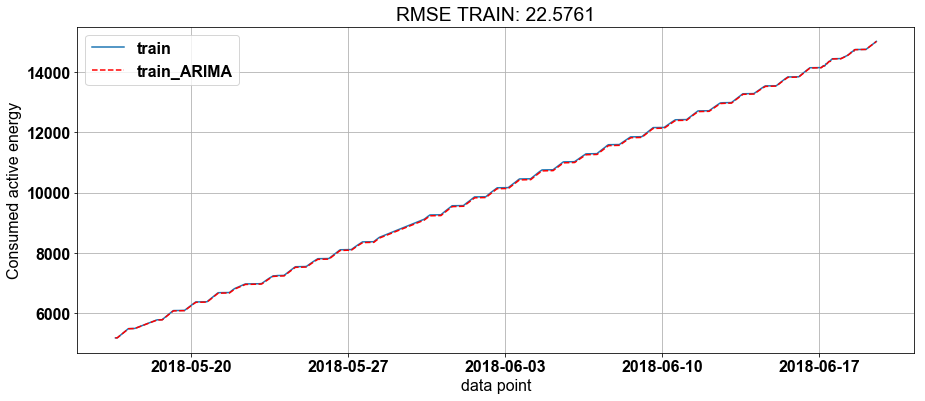

In [38]:
plt.gcf()
plt.clf()
#take back
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(train_log.ix[0], index=train_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)

plt.plot(train,label='train')
plt.plot(predictions_ARIMA,label='train_ARIMA',ls='--',color='red')
plt.title('RMSE TRAIN: %.4f'% np.sqrt(sum((predictions_ARIMA-train)**2)/train_size))
res_file.write('%.4f, '% (np.sqrt(sum((predictions_ARIMA-train)**2)/train_size)))
print('RMSE TRAIN %.4f, '% (np.sqrt(sum((predictions_ARIMA-train)**2)/train_size)))
plt.xlabel("data point")
plt.ylabel("Consumed active energy")
plt.legend()
plt.grid("on")
plt.savefig('acf-'+str(p)+'-'+str(d)+'-'+str(q)+'-predicted-trained.png')
plt.show()




/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


RMSE TEST 2731.5505, 


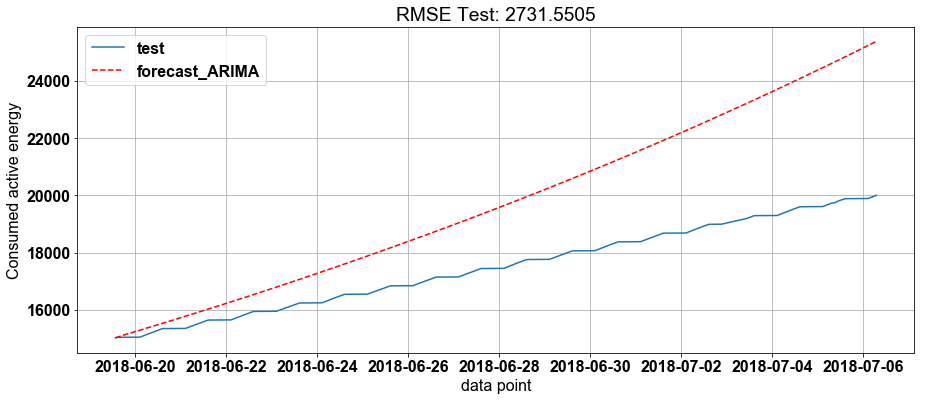

In [35]:
#predict
forecast = results_ARIMA.predict(start=start_index,end=end_index)
plt.gcf()
plt.clf()
#take back
predictions_ARIMA_diff = pd.Series(forecast, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(test_log.ix[0], index=test_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
#for i in range(len(test)):
#    print(test[i],predictions_ARIMA[i])
plt.plot(test,label='test')
plt.plot(predictions_ARIMA,label='forecast_ARIMA',ls='--',color='red')
plt.legend()
plt.title('RMSE Test: %.4f'% np.sqrt(sum((predictions_ARIMA-test)**2)/test_size))
res_file.write('%.4f\n'% (np.sqrt(sum((predictions_ARIMA-test)**2)/test_size)))
print('RMSE TEST %.4f, '% (np.sqrt(sum((predictions_ARIMA-test)**2)/test_size)))
plt.xlabel("data point")
plt.ylabel("Consumed active energy")
plt.grid("on")
plt.savefig( 'acf-'+str(p)+'-'+str(d)+'-'+str(q)+'-predicted-test.png')
res_file.close()

In [ ]:
#auto arima
from pyramid.arima import auto_arima
stepwise_model = auto_arima(data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())
